## Web scraping and pickling the data

In [2]:
import requests
import bs4
import pickle

urls = [
    "https://www.nytimes.com/interactive/2020/01/31/us/politics/pete-buttigieg-campaign-speech.html",
    "https://www.nytimes.com/interactive/2020/01/31/us/politics/joe-biden-campaign-speech.html",
    "https://www.nytimes.com/interactive/2020/01/31/us/politics/amy-klobuchar-campaign-speech.html",
    "https://www.nytimes.com/interactive/2020/01/31/us/politics/bernie-sanders-campaign-speech.html",
    "https://www.nytimes.com/interactive/2020/01/31/us/politics/elizabeth-warren-campaign-speech.html",
    "https://www.nytimes.com/interactive/2020/01/31/us/politics/andrew-yang-campaign-speech.html"]


def url_to_transcript_nytimes(url):
    r =  requests.get(url)
    soup = bs4.BeautifulSoup(r.text, "html.parser")
    content = soup.find_all('p', attrs={'class': 'g-body'})
    text = ""
    for txt in content:
        text += txt.text
    return text
    
democrats = ["Pete Buttigieg", "Joe Biden", "Amy Klobuchar", "Bernie Sanders", "Elizabeth Warren", "Andrew Yang"]


In [3]:
# Requests to transcripts
transcripts = [url_to_transcript_nytimes(u) for u in urls]

In [4]:
# Pickle for later use
!mkdir transcripts
for i, c in enumerate(democrats):
    with open("transcripts/" + c + ".txt", "wb") as file:
        pickle.dump(transcripts[i], file)

A subdirectory or file transcripts already exists.


## Data cleaning

In [5]:
# Read pickle for use
data = {}
for i, c in enumerate(democrats):
    with open("transcripts/" + c + ".txt", "rb") as file:
        data[c] = pickle.load(file)

In [6]:
# Combines the text
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ''.join(list_of_text)
    return combined_text

In [7]:
data_combined = {key: [combine_text(value)] for (key, value) in data.items()}

In [8]:
# Data is put in a pandas dataframe, this form is called Corpus

import pandas as pd
pd.set_option('max_colwidth',150)
democrats.sort()

df = pd.DataFrame.from_dict(data_combined).transpose()
df.columns = ['transcript']
df = df.sort_index()
df['politician'] = democrats
df

,transcript,politician
Amy Klobuchar,\n\tThe central thrust of Senator Amy Klobuchar of Minnesota’s closing message before the Iowa caucuses can be captured in just three words: I can...,Amy Klobuchar
Andrew Yang,"\n\tThe businessman and entrepreneur Andrew Yang has won support by pitching himself as a numbers-driven truth teller, whose status as a political...",Andrew Yang
Bernie Sanders,"\n\tSenator Bernie Sanders of Vermont has delivered a similar stump speech for decades, championing a vision for the country that serves working- ...",Bernie Sanders
Elizabeth Warren,"\n\tSenator Elizabeth Warren of Massachusetts and President Trump are radically different politicians, but her closing message before the Iowa cau...",Elizabeth Warren
Joe Biden,\n\tFormer Vice President Joseph R. Biden Jr. casts himself as an experienced hand who can appeal to black voters nationwide and win in the Midwes...,Joe Biden
Pete Buttigieg,"\n\tPete Buttigieg, the former mayor of South Bend, Ind., delivers a tight stump speech — usually about 12 to 15 minutes long — that is heavy on h...",Pete Buttigieg


In [9]:
import re
import string

# Using regex to remove noise from the texts - should be split into two

def clean_data_1(text):
    """ Clean data part 1: Lower case,  """
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', '', text)
    text = re.sub('\b', '', text)
    text = re.sub('[^a-z ]+', '', text)
    text = re.sub('\s\s+', ' ', text)
    return text

round1 = lambda x: clean_data_1(x)

In [10]:
data_clean = pd.DataFrame(df.transcript.apply(round1))
data_clean


,transcript
Amy Klobuchar,the central thrust of senator amy klobuchar of minnesotas closing message before the iowa caucuses can be captured in just three words i can win ...
Andrew Yang,the businessman and entrepreneur andrew yang has won support by pitching himself as a numbersdriven truth teller whose status as a political outs...
Bernie Sanders,senator bernie sanders of vermont has delivered a similar stump speech for decades championing a vision for the country that serves working and m...
Elizabeth Warren,senator elizabeth warren of massachusetts and president trump are radically different politicians but her closing message before the iowa caucuse...
Joe Biden,former vice president joseph r biden jr casts himself as an experienced hand who can appeal to black voters nationwide and win in the midwest on ...
Pete Buttigieg,pete buttigieg the former mayor of south bend ind delivers a tight stump speech usually about to minutes long that is heavy on his big thematic i...


In [11]:
#  data_clean.transcript.loc['Andrew Yang']

In [12]:
# For lemmatization we use WordNet, but we need to POS-tag the tokenized words for a more accurate lemmatization
import nltk
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
from nltk.stem import WordNetLemmatizer

def lemmatize_transcript(text):
    ''' Tokenizes text and for each tokenized word, it applies a POS-tag and lemmatizes the word
        Returns the lemmatized output as a string
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(text)])
    return lemmatized_output

lemma = lambda x: lemmatize_transcript(x)

In [14]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

data_clean_lemma = pd.DataFrame(data_clean.transcript.apply(lemma))
data_clean_lemma

,transcript
Amy Klobuchar,the central thrust of senator amy klobuchar of minnesota closing message before the iowa caucus can be capture in just three word i can win while ...
Andrew Yang,the businessman and entrepreneur andrew yang have won support by pitch himself a a numbersdriven truth teller whose status a a political outsider ...
Bernie Sanders,senator bernie sander of vermont have deliver a similar stump speech for decade champion a vision for the country that serf work and middleclass a...
Elizabeth Warren,senator elizabeth warren of massachusetts and president trump be radically different politician but her closing message before the iowa caucus may...
Joe Biden,former vice president joseph r biden jr cast himself a an experienced hand who can appeal to black voter nationwide and win in the midwest on the ...
Pete Buttigieg,pete buttigieg the former mayor of south bend ind delivers a tight stump speech usually about to minute long that be heavy on his big thematic ide...


In [15]:
# Tokenization of the transcripts and creation of DTM (Document-term Matrix)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

# Add stop words manually
add_stop_words = ['just', 'like', 'got', 'things', 'thing', 'thats', 'know', 'said', 'going', 'dont', 'sure', 'mr', 'let', 'gon', 'na', 'say', 'want', 'year', 'time', 'end', 'way', 'talk', 'ive', 'im', 'tell', 'think', 'lot', 'mean', 'day', 'make', 'wait', 'right', 'youre', 'come', 'bring', 'theyre', 'ready', 'yeah', 'yes', 'buttigieg', 'klobuchar', 'yang', 'sander', 'warren', 'biden', 'people', 'country', 'oh', 'in']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean_lemma.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean_lemma.index
data_dtm

,aa,abby,ability,able,abroad,absolutely,absurd,absurdity,abuse,accelerate,...,writes,wrong,yesterday,york,youll,young,youve,zero,zeroed,zone
Amy Klobuchar,1,0,0,8,0,0,0,0,0,0,...,0,1,1,0,0,0,3,0,0,0
Andrew Yang,0,0,0,0,0,0,0,0,1,1,...,0,5,0,0,1,0,3,5,1,1
Bernie Sanders,0,0,0,3,1,1,1,1,0,0,...,1,2,0,2,3,6,9,2,0,0
Elizabeth Warren,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Joe Biden,0,1,0,2,0,0,0,0,1,0,...,0,0,0,0,0,4,0,0,0,0
Pete Buttigieg,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [16]:
# Pickle the data - not needed
data_dtm.to_pickle("dtm.pkl")

In [17]:
# Pickle data_clean_lemme - not needed
data_clean_lemma.to_pickle('data_clean_lemma.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

## Exploratory Data Analysis

### Most used words

In [18]:
data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data.head()

,Amy Klobuchar,Andrew Yang,Bernie Sanders,Elizabeth Warren,Joe Biden,Pete Buttigieg
aa,1,0,0,0,0,0
abby,0,0,0,0,1,0
ability,0,0,0,0,0,1
able,8,0,3,1,2,0
abroad,0,0,1,0,0,0


In [19]:
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [20]:
for politician, top_words in top_dict.items():
    print(politician)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

Amy Klobuchar
state, care, big, health, really, win, worker, iowa, work, need, pay, rural, weve, life
---
Andrew Yang
work, job, iowa, america, president, trump, american, great, donald, dc, start, life, truck, economy
---
Bernie Sanders
health, care, america, pay, work, medicare, family, today, percent, trump, american, campaign, company, million
---
Elizabeth Warren
work, school, law, teacher, money, job, story, teach, oklahoma, change, little, good, old, life
---
Joe Biden
world, president, america, middle, great, state, class, iran, help, american, war, reason, united, folk
---
Pete Buttigieg
value, president, need, life, american, democracy, freedom, iowa, love, belong, state, honor, sun, believe
---


### Wordcloud

In [21]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

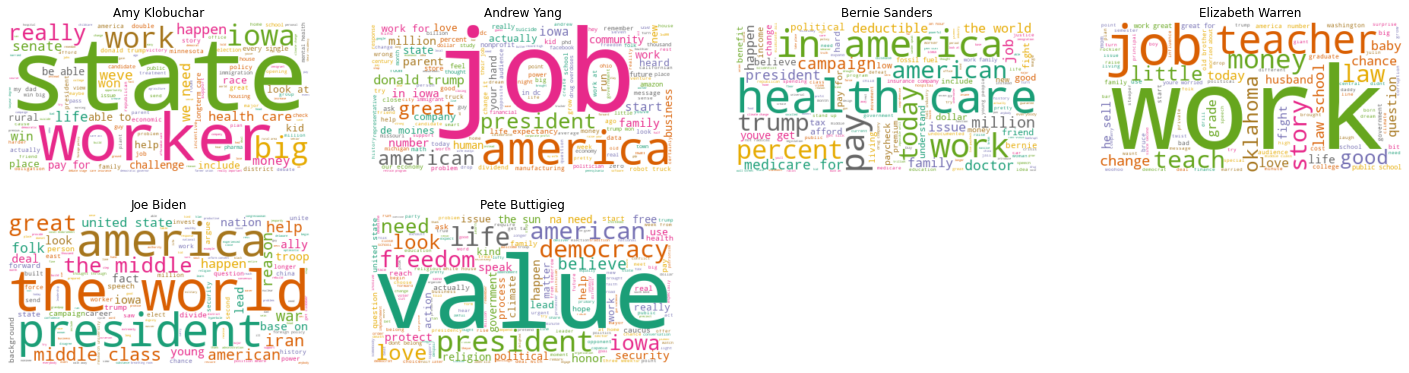

In [28]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [25 , 10]

# Create subplots for each politician
for index, democrat in enumerate(data.columns):
    wc.generate(data_clean_lemma.transcript[democrat])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(democrats[index])
    
plt.show()

### Characteristic terms and associations

In [29]:
import scattertext as st
import spacy

nlp = spacy.load('en_core_web_sm')

data_clean_lemma['politician'] = democrats

corpus = st.CorpusFromPandas(data_clean_lemma, category_col='politician', text_col='transcript', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:20]))

ModuleNotFoundError: No module named 'scattertext'

In [30]:
# Term frequency - bigram
def term_freq(politician):
    term_freq_df = corpus.get_term_freq_df()
    term_freq_df['Score'] = corpus.get_scaled_f_scores(politician)
    print(term_freq_df.sort_values(by='Score', ascending=False).index[:20])

for x in democrats: 
    print(x)  
    term_freq(x)
    print('---------')   

Amy Klobuchar


NameError: name 'corpus' is not defined

### Unique words / vocabulary

In [32]:
list_words = []
total_list = []

for dem in data.columns:
    uniques = data[dem].to_numpy().nonzero()[0].size
    list_words.append(uniques)
    totals = sum(data[dem])
    total_list.append(totals)

data_words = pd.DataFrame(list(zip(democrats, list_words)), columns=['politician', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words', ascending=False)
data_words['total_words'] = total_list
data_total_sort = data_words.sort_values(by='total_words', ascending=False)
data_unique_sort

,politician,unique_words
2,Bernie Sanders,810
1,Andrew Yang,760
0,Amy Klobuchar,680
5,Pete Buttigieg,484
4,Joe Biden,480
3,Elizabeth Warren,302


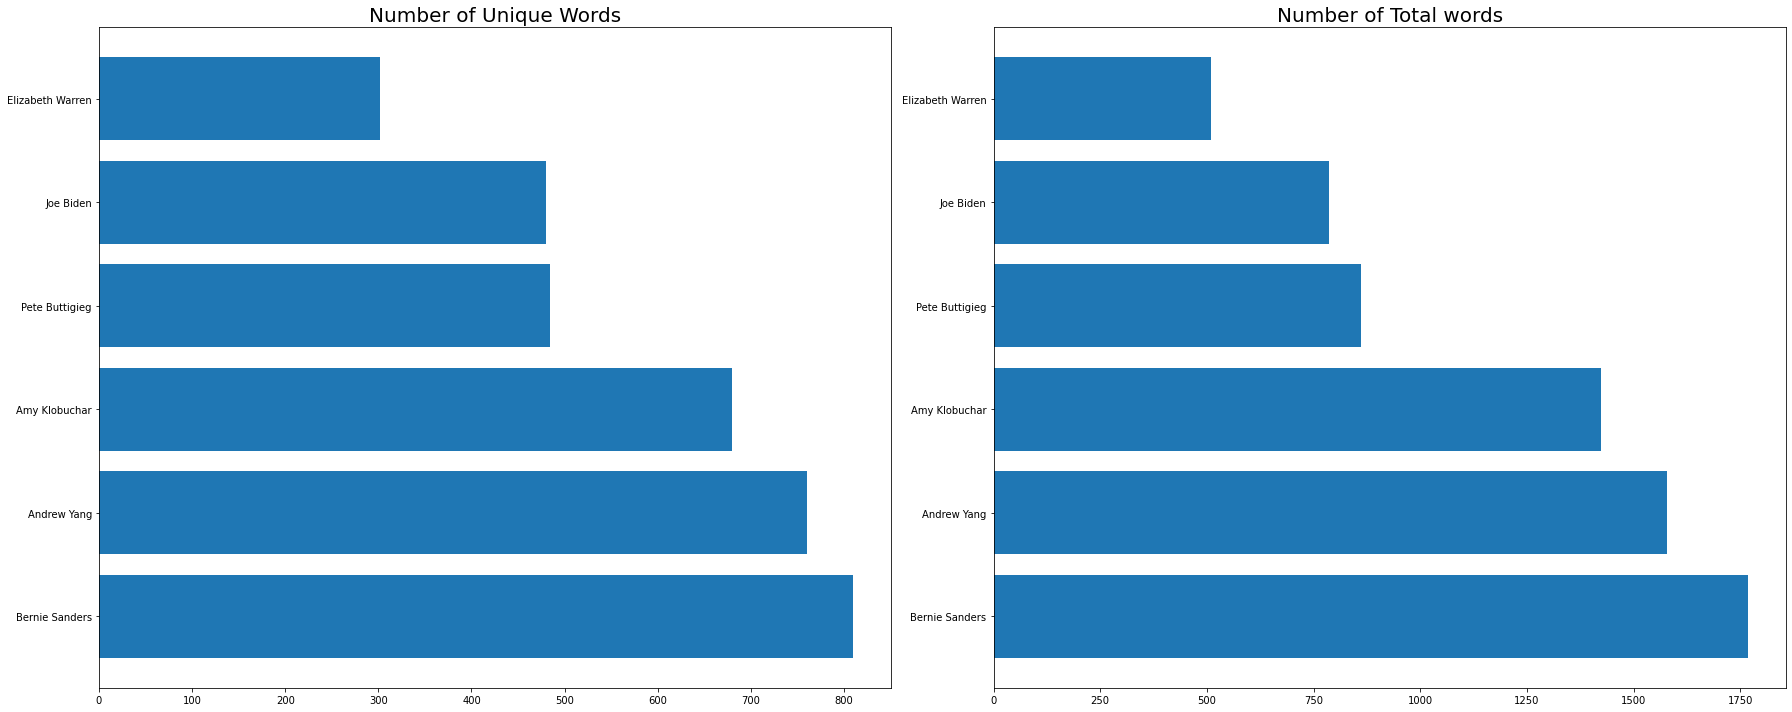

In [33]:
import numpy as np
import matplotlib.pyplot as plt

y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.politician)
plt.title('Number of Unique Words', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(y_pos, data_total_sort.total_words, align='center')
plt.yticks(y_pos, data_total_sort.politician)
plt.title('Number of Total words', fontsize=20)

plt.tight_layout()
plt.show()

### Topic modeling

In [34]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Trying to Topic Modeling 

lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=50, random_state=0).fit(data_dtm)

no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic %d:' % (topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

fn = cv.get_feature_names()
display_topics(lda_model, fn, no_top_words)

Topic 0:
pay health america care state work trump president life family
Topic 1:
value president need life democracy american freedom belong love state
Topic 2:
work care america job health million iowa percent president need
Topic 3:
america work state job president health care change iowa american
Topic 4:
work care america health state job president iowa trump pay


In [35]:
import pyLDAvis
import pyLDAvis.sklearn

# using sklearn and pyLDAvis we see that it only found 2 topics, and those being ambiguous or rather large. The problem could be the amount of data used, but also the sircumstance
# of the speeches. A really hot topic of the speeches are about healthcare, which is most likely the number 1 topic.

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_cv, cv, mds='tsne')
panel

ModuleNotFoundError: No module named 'pyLDAvis'

### TF-IDF - Topic modeling

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creation of vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, use_idf=True)

# Fit on our data
tfidf = tfidf_vectorizer.fit_transform(data_clean_lemma['transcript'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [37]:
dtm_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
dtm_tfidf.index = data_clean_lemma.index
dtm_tfidf

,able,abuse,access,accord,acknowledge,act,action,active,actually,ad,...,write,wrong,yeah,yes,yet,youll,young,yourself,youve,zero
Amy Klobuchar,0.096245,0.000000,0.014039,0.000000,0.016629,0.031168,0.012031,0.000000,0.062336,0.033258,...,0.000000,0.014039,0.033258,0.020779,0.036092,0.000000,0.000000,0.016629,0.036092,0.000000
Andrew Yang,0.000000,0.018441,0.015569,0.000000,0.018441,0.011521,0.000000,0.000000,0.080649,0.055322,...,0.000000,0.077844,0.073763,0.023043,0.000000,0.018441,0.000000,0.000000,0.040024,0.077844
Bernie Sanders,0.029805,0.000000,0.000000,0.013732,0.000000,0.017159,0.009935,0.000000,0.025739,0.000000,...,0.013732,0.023187,0.000000,0.008580,0.049674,0.041197,0.082393,0.000000,0.089414,0.023187
Elizabeth Warren,0.027770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038384,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.023982,0.027770,0.000000,0.000000,0.000000,0.000000,0.000000
Joe Biden,0.042246,0.029197,0.000000,0.000000,0.000000,0.018242,0.021123,0.000000,0.018242,0.000000,...,0.029197,0.000000,0.000000,0.000000,0.021123,0.000000,0.116788,0.000000,0.000000,0.000000
Pete Buttigieg,0.000000,0.000000,0.019883,0.023551,0.000000,0.044143,0.068154,0.023551,0.058857,0.000000,...,0.000000,0.000000,0.000000,0.014714,0.000000,0.000000,0.000000,0.023551,0.017039,0.019883


In [40]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

nmf = NMF(n_components=6, random_state=0, alpha=.1).fit(dtm_tfidf)

In [104]:
display_topics(nmf, tfidf_feature_names, no_top_words)

# Topic 0 = Health care / medicare
# Topic 1 = Education
# Topic 2 = Middle class (war?)
# Topic 3 = Democracy / freedom
# Topic 4 = Family/Community
# Topic 5 = Working class, rural area, healtcare ?

Topic 0:
health care mean pay system medicare which percent end today
Topic 1:
law school teach teacher story her money grade baby much
Topic 2:
world middle class his war help position without ally young
Topic 3:
gon na value ready freedom mean wait where sure could
Topic 4:
many some parent american oh community an donald human number
Topic 5:
care his big rural really win where bring worker health


In [42]:
nmf_topic_values = nmf.transform(tfidf)
data_clean_lemma['nmf_topics'] = nmf_topic_values.argmax(axis=1)

In [43]:
nmf_remap = {0: 'Healthcare/Medicare', 1: 'Education', 2: 'Middle class', 3: 'Democracy/Freedom', 4: 'Family/Community', 5: 'Working class'}

data_clean_lemma['nmf_topics'] = data_clean_lemma['nmf_topics'].map(nmf_remap)

In [44]:
data_clean_lemma

,transcript,nmf_topics
Amy Klobuchar,the central thrust of senator amy klobuchar of minnesota closing message before the iowa caucus can be capture in just three word i can win while ...,Working class
Andrew Yang,the businessman and entrepreneur andrew yang have won support by pitch himself a a numbersdriven truth teller whose status a a political outsider ...,Family/Community
Bernie Sanders,senator bernie sander of vermont have deliver a similar stump speech for decade champion a vision for the country that serf work and middleclass a...,Healthcare/Medicare
Elizabeth Warren,senator elizabeth warren of massachusetts and president trump be radically different politician but her closing message before the iowa caucus may...,Education
Joe Biden,former vice president joseph r biden jr cast himself a an experienced hand who can appeal to black voter nationwide and win in the midwest on the ...,Middle class
Pete Buttigieg,pete buttigieg the former mayor of south bend ind delivers a tight stump speech usually about to minute long that be heavy on his big thematic ide...,Democracy/Freedom


# Sentiment Analysis

In [108]:
from textblob import TextBlob

data_clean_lemma['polarity'] = data_clean_lemma['transcript'].apply(lambda x: TextBlob(x).sentiment.polarity)
data_clean_lemma['subjectivity'] = data_clean_lemma['transcript'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [109]:
data_clean_lemma

,transcript,nmf_topics,polarity,subjectivity
Amy Klobuchar,the central thrust of senator amy klobuchar of minnesota closing message before the iowa caucus can be capture in just three word i can win while ...,Working class,0.161790,0.396293
Andrew Yang,the businessman and entrepreneur andrew yang have won support by pitch himself a a numbersdriven truth teller whose status a a political outsider ...,Family/Community,0.147986,0.414217
Bernie Sanders,senator bernie sander of vermont have deliver a similar stump speech for decade champion a vision for the country that serf work and middleclass a...,Healthcare/Medicare,0.033466,0.502444
Elizabeth Warren,senator elizabeth warren of massachusetts and president trump be radically different politician but her closing message before the iowa caucus may...,Education,0.124056,0.368348
Joe Biden,former vice president joseph r biden jr cast himself a an experienced hand who can appeal to black voter nationwide and win in the midwest on the ...,Middle class,0.147595,0.418754
Pete Buttigieg,pete buttigieg the former mayor of south bend ind delivers a tight stump speech usually about to minute long that be heavy on his big thematic ide...,Democracy/Freedom,0.110051,0.459323
